In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# Global variable mapping ints to strings
DAYMAP = {0: 'Monday', 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

In [3]:
#Answer to 1
jan = pd.read_csv('./clean-january.csv')

jan['short_trip'] = jan['trip_distance'].apply(lambda x: 1 if x < 3 else 0)
count = jan['short_trip'].sum()

# These are what we want to access to store in a 
# the new dataframe.
cols = ['short_trip', 'trip_distance', 'passenger_count', 'payment_amount', 'duration']
new_cols = ['Short_Trip', 'Trip_distance', 'Passenger_count', 'Payment_amount', 'Duration']

# Create a new dataframe satisfying the schema in Q1.
new_jan = pd.DataFrame()
new_jan['Index'] = jan.index.tolist()
new_jan[new_cols] = jan[cols]

print('Question 1')
print('% of short trips={0:.1f}'.format((count/(new_jan['Short_Trip'].shape[0]))*100))
print('*'*3)

Question 1
% of short trips=71.3
***


In [4]:
# Answer to question 2
print('Question 2 median trip distance')
print('January:', jan['trip_distance'].median())
print('*'*3)
print('Question 2 median trip duration')
print('January', jan['duration'].median())
print('*'*3)

Question 2 median trip distance
January: 1.82
***
Question 2 median trip duration
January 11.0
***


In [5]:
# Answer to question 3
# The amount of normal values is the sum of the boolean values
# of the series between 1.2 and 4.5
normal_count = jan['trip_distance'].between(1.2, 4.5).sum()
total_count = jan['trip_distance'].shape[0]
print('Question 3')
# The abnormal count is the total count
# less the normal count.
print("{0:.1f}% of instances in ‘tripdistance’ are abnormal! (normal range is between 1.2 and 4.5)"
      .format(100*(total_count-normal_count)/(total_count)))
print('*'*3)

Question 3
42.9% of instances in ‘tripdistance’ are abnormal! (normal range is between 1.2 and 4.5)
***


In [6]:
# Costly operations in this cell, so we dont rerun the same op.
jan['pickup_datetime'] = pd.to_datetime(jan['pickup_datetime'], format='%d/%m/%y %H:%M')
jan['dropoff_datetime'] = pd.to_datetime(jan['dropoff_datetime'], format='%d/%m/%y %H:%M')

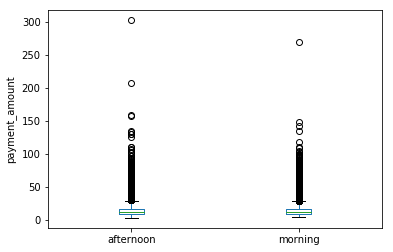

In [7]:
#Answer to question 4
pickup = jan['pickup_datetime']
#Turn the hours into a floating point representation so we may plot it.
pickup_fp= pickup.apply(lambda x: x.hour + (x.minute/60))
# obtain boolean values indicating if the requirement was met.
morning = pickup_fp.between(7.00, 11.00)
afternoon = pickup_fp.between(12.00, 15.00)
jan['pickup_fp'] = pickup_fp # in case we need it later
fares = jan['payment_amount']
pd.DataFrame({"morning": fares[morning],"afternoon": fares[afternoon]}).plot.box()
plt.ylabel('payment_amount')
plt.show()

In [8]:
# Answer to question 5
def checkpeak(x):
    if x.hour >= 7:
        if x.hour <= 8:
            if x.weekday() < 5:
                return 1
    return 0
    
jan['isPeak'] = jan['pickup_datetime'].apply(lambda x: checkpeak(x))
# We perform an and operation since we need to check 
# if both conditions were met, this works for trips greater than a day as well.
jan['isPeak'] = jan['isPeak'] & jan['dropoff_datetime'].apply(lambda x: checkpeak(x))
print('Question 5')
print('% of peak hour trips={0:.01f}'.format(jan['isPeak'].sum()/jan.shape[0]*100))

Question 5
% of peak hour trips=6.2


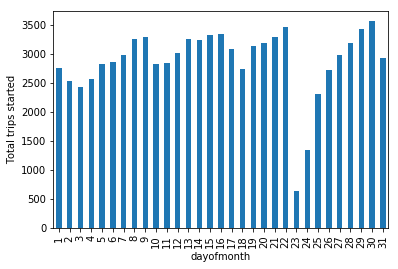

In [9]:
# Answer to question 6
jan['dayofmonth'] = jan['pickup_datetime'].apply(lambda x: x.day)
data = jan[['dayofmonth']].groupby('dayofmonth').size()
data.plot(kind='bar')
plt.ylabel('Total trips started')
plt.show()

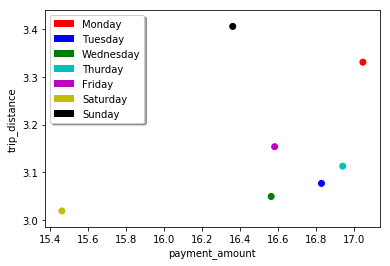

In [10]:
# Answer to question 7
jan['dayofweek'] = jan['pickup_datetime'].apply(lambda x: x.weekday())
# monday, tuesday ... sunday
dmap = DAYMAP.values()
# The values for monday, teusday .. sunday
cmap = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
# Store the x and y values, since I will be using matplotlib
x= []
y = []
# we could have used groupby, but that would
# not have given us an ordered legend.
# So for graph readability, I believe this 
# part is justified.
for i in range(0, 7):
    # extract day info
    curr_week = jan[jan['dayofweek']==i]
    y.append(curr_week['trip_distance'].mean())
    x.append(curr_week['payment_amount'].mean())
plt.scatter(x, y, c=cmap)
plt.xlabel('payment_amount')
plt.ylabel('trip_distance')
recs = []
# draw the legend.
for i in range(0,len(cmap)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=cmap[i]))
plt.legend(recs,dmap,loc='upper left', shadow=True, fancybox=True)
plt.show()

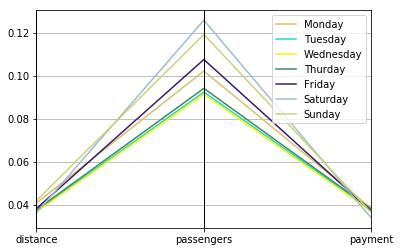

In [11]:
# Answer to question 8
def norm(df):
    df_min = df.min()
    df_max = df.max()
    return (df-df_min)/(df_max-df_min)

normalised = pd.DataFrame(columns=['weekday', 'distance', 'passengers', 'payment'])

jan['n_trip_distance'] = norm(jan['trip_distance'])
jan['n_passenger_count'] = norm(jan['passenger_count'])
jan['n_payment_amount'] = norm(jan['payment_amount'])

# we could have used groupby, but that would
# not have given us an ordered legend.
# So for graph readability, I believe this 
# part is justified.
for i in range(0, 7):
    # extract the weekday information for current day
    curr_week = jan[jan['dayofweek']==i]
    # get day as a string
    day = DAYMAP[i]
    # get the mean values
    nm_dist = curr_week['n_trip_distance'].mean()
    nm_pass_cn = curr_week['n_passenger_count'].mean()
    nm_pay = curr_week['n_payment_amount'].mean()
    # add a new row to the pandas dataframe
    normalised.loc[len(normalised)] = [day, nm_dist, nm_pass_cn, nm_pay]
    
pd.plotting.parallel_coordinates(normalised, 'weekday')
plt.show()

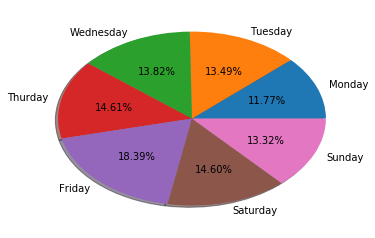

In [12]:
# Answer to question 9
jan['minutes_travelling'] = jan['passenger_count'] * jan['duration']
df = jan[['dayofweek', 'minutes_travelling']]
# I dont believe the legend should be
# ordered for a pie chart, hence I used groupby.
plt.pie(df.groupby('dayofweek').sum(), 
        labels=DAYMAP.values(),
        autopct="%1.2f%%",
        shadow=True
        
       )
plt.show()

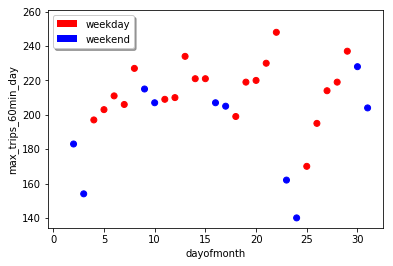

In [13]:
# Answer to question 10

def maxtrips(s):
    max_trips = 0
    for time in s:
        trips = s.between(time, time+1.0).sum()
        if trips > max_trips:
            max_trips = trips
    return max_trips
# Get the relevant columns and store them in a dataframe.
time_df = jan[['pickup_datetime','dropoff_datetime', 'pickup_fp', 'dayofweek', 'dayofmonth']]
# Only obtain the items that started and finished on the same day.
time_df= time_df[time_df.apply(lambda row: row['pickup_datetime'].date()==row['dropoff_datetime'].date(), axis=1)]
# The mean is useless, only used to remove duplicates.
cmap = time_df.groupby('dayofmonth').mean().reset_index()
# get a colour vector.
cmap = cmap['dayofweek'].apply(lambda x: 'r' if x < 5 else 'b')
x = [i for i in range(1, 32)]
y = []
for i in range(1, 32):
    # We use pickup_fp since it is much faster
    # than dealing with the datetime module.
    y.append(maxtrips(time_df[time_df['dayofmonth']==i]['pickup_fp']))
plt.scatter(x, y, c=cmap)
recs = []
cmap = ['r', 'b']
legends = ['weekday', 'weekend']
# draw the legend.
for i in range(0,len(cmap)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=cmap[i]))
plt.legend(recs,legends,loc='upper left', shadow=True, fancybox=True)
plt.xlabel('dayofmonth')
plt.ylabel('max_trips_60min_day')
plt.show()
    

    